In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, LassoCV

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
contra = pd.read_csv("contraceptive_for_students.csv")

In [3]:
contra.head(5)

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [4]:
contra.shape

(1473, 10)

# **Initial Data Cleaning**

In [5]:
#data cleaning. See if there's any missing value in the dataset.
contra.isnull().sum()
#No missing values

wife_age              0
wife_education        0
husband_education     0
num_child             0
wife_religion         0
wife_work             0
husband_occupation    0
standard_living       0
media_exposure        0
contraceptive         0
dtype: int64

In [6]:
#Changing husband occupation/wife working / media exposure values to more conventional values

def replace_val(df, cols, old, new):
  #df: dataframe
  #cols: list of columns
  #old: list of old values ---- new: list of new values
  df[cols] = df[cols].replace(old, new)

#1=No-use, 2=Long-term, 3=Short-term ->>> 1=No-use, 2=Short-term, 3=Short-term
replace_val(contra, ["contraceptive"], [1, 2, 3], [1, 3, 2]) 

#0=Yes, 1=No ->>> 0=No, 1=Yes
replace_val(contra, ["wife_work", "media_exposure"], [0, 1], [1, 0])

##1=Professional, 2=Sales, 3=Manual, 4=Agriculture ->>> 4=Professional, 3=Sales, 2=Manual, 1=Agriculture
replace_val(contra, "husband_occupation", [1, 2, 3, 4], [4, 3, 2, 1])

#Created an additional copy for EDA 
contra.head(5)
contra_copy = contra.copy(deep=True)

# **FEATURE ENGINEERING**

In [7]:
#Changing nominal numerical numbers to qualitative terms for one-hot encoding.

def replace_val(df, cols, old, new):
  #df: dataframe
  #cols: list of columns
  #old: list of old values ---- new: list of new values
  df[cols] = df[cols].replace(old, new)

replace_val(contra, ["standard_living", "wife_education",	"husband_education"], [1, 2, 3, 4], ["Low", "Low-Medium", "Medium", "High"])
replace_val(contra, ["wife_work"], [0, 1], ["No", "Yes"])
replace_val(contra, ["husband_occupation"], [4, 3, 2, 1], ["Professional", "Sales", "Manual", "Agriculture"])
replace_val(contra, ["media_exposure"], [0, 1], ["Not Good", "Good"])
replace_val(contra, ['wife_religion'], [0, 1], ['Non-Islam', 'Islam'])
contra.head(5)


,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,Low-Medium,Medium,3,Islam,No,Sales,Medium,Good,1
1,45,Low,Medium,10,Islam,No,Manual,High,Good,1
2,43,Low-Medium,Medium,7,Islam,No,Manual,High,Good,1
3,42,Medium,Low-Medium,9,Islam,No,Manual,Medium,Good,1
4,36,Medium,Medium,8,Islam,No,Manual,Low-Medium,Good,1


In [8]:
#One-hot-encoding the dataset

from sklearn.feature_extraction import DictVectorizer

cate_cols = ['wife_education', 'husband_education',	'wife_religion',	'wife_work',	'husband_occupation',	'standard_living',	'media_exposure']

def ohe_qu(data):
    vec_enc = DictVectorizer()
    vec_enc.fit(data[cate_cols].to_dict(orient='records'))
    qu_data = vec_enc.transform(data[cate_cols].to_dict(orient='records')).toarray()
    qu_cats = vec_enc.get_feature_names()
    all_qu = pd.DataFrame(qu_data, columns=qu_cats)
    data = pd.concat([data.drop(columns = cate_cols), all_qu], axis=1)
    return data

contra = ohe_qu(contra)
contra.head(5)

,wife_age,num_child,contraceptive,husband_education=High,husband_education=Low,husband_education=Low-Medium,husband_education=Medium,husband_occupation=Agriculture,husband_occupation=Manual,husband_occupation=Professional,...,standard_living=Low-Medium,standard_living=Medium,wife_education=High,wife_education=Low,wife_education=Low-Medium,wife_education=Medium,wife_religion=Islam,wife_religion=Non-Islam,wife_work=No,wife_work=Yes
0,24,3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,45,10,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,43,7,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,42,9,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,36,8,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


# **HIGHLY CORRELATED FEATURES**

In [9]:
#Absolute correlation with contraceptive methods
contra_target = contra.corr()
corr = abs(contra_target['contraceptive'])
#Selecting highly correlated features
corr_features = corr[corr>0.15]
corr_features.drop(labels = ['contraceptive'], inplace=True)
corr_features.sort_values(ascending=False, inplace=True)
corr_features

wife_education=High                0.262870
wife_education=Low                 0.180913
husband_education=High             0.177229
husband_occupation=Professional    0.162662
standard_living=High               0.162512
Name: contraceptive, dtype: float64

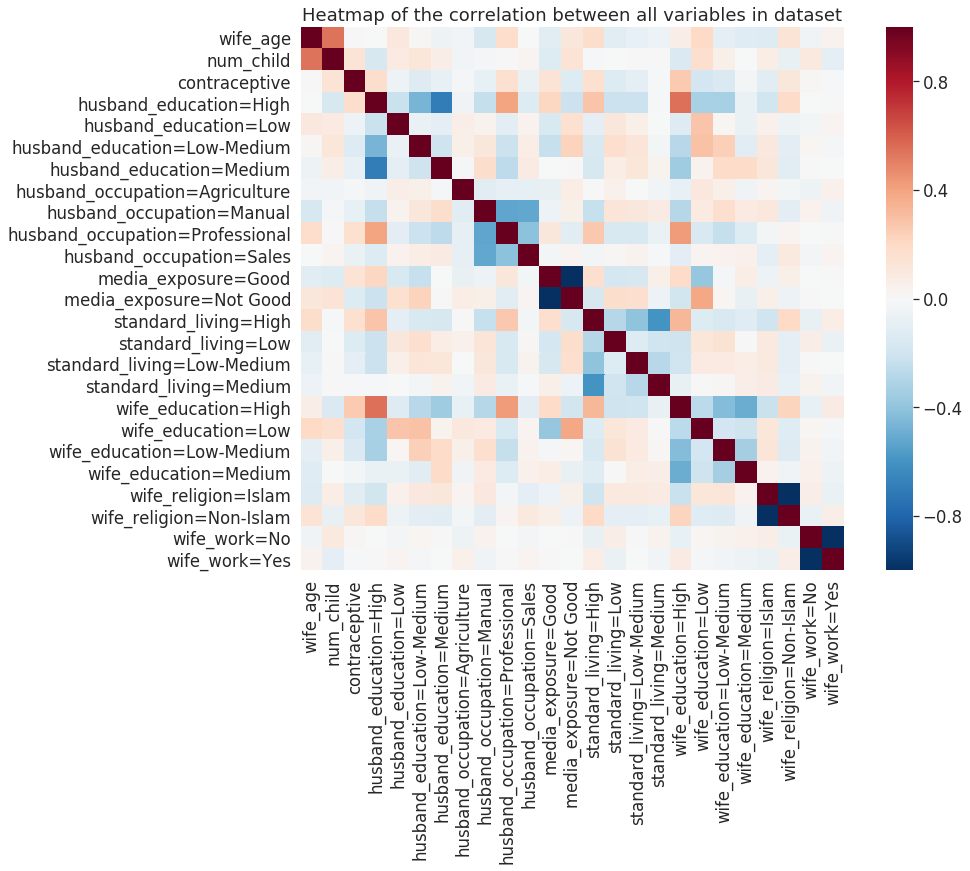

In [10]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(contra_target, mask=np.zeros_like(contra_target, dtype=np.bool), cmap="RdBu_r",
            square=True, ax=ax)
plt.title("Heatmap of the correlation between all variables in dataset")
plt.show();

#Corr of interest: wife_age/num_child vs wife_age/contra, wife_education/husband_Education, wife_education/standard_living vs husband_education/standard_living, standard_living/contra, wife_edu/contra vs husband_edu/contra. media_exposure/colntra, media_exposure/standard_living. wife_edu/husband_edu --> even if wife isn't working, husband's occupation is still high if her education is high?

<Figure size 1440x1440 with 0 Axes>

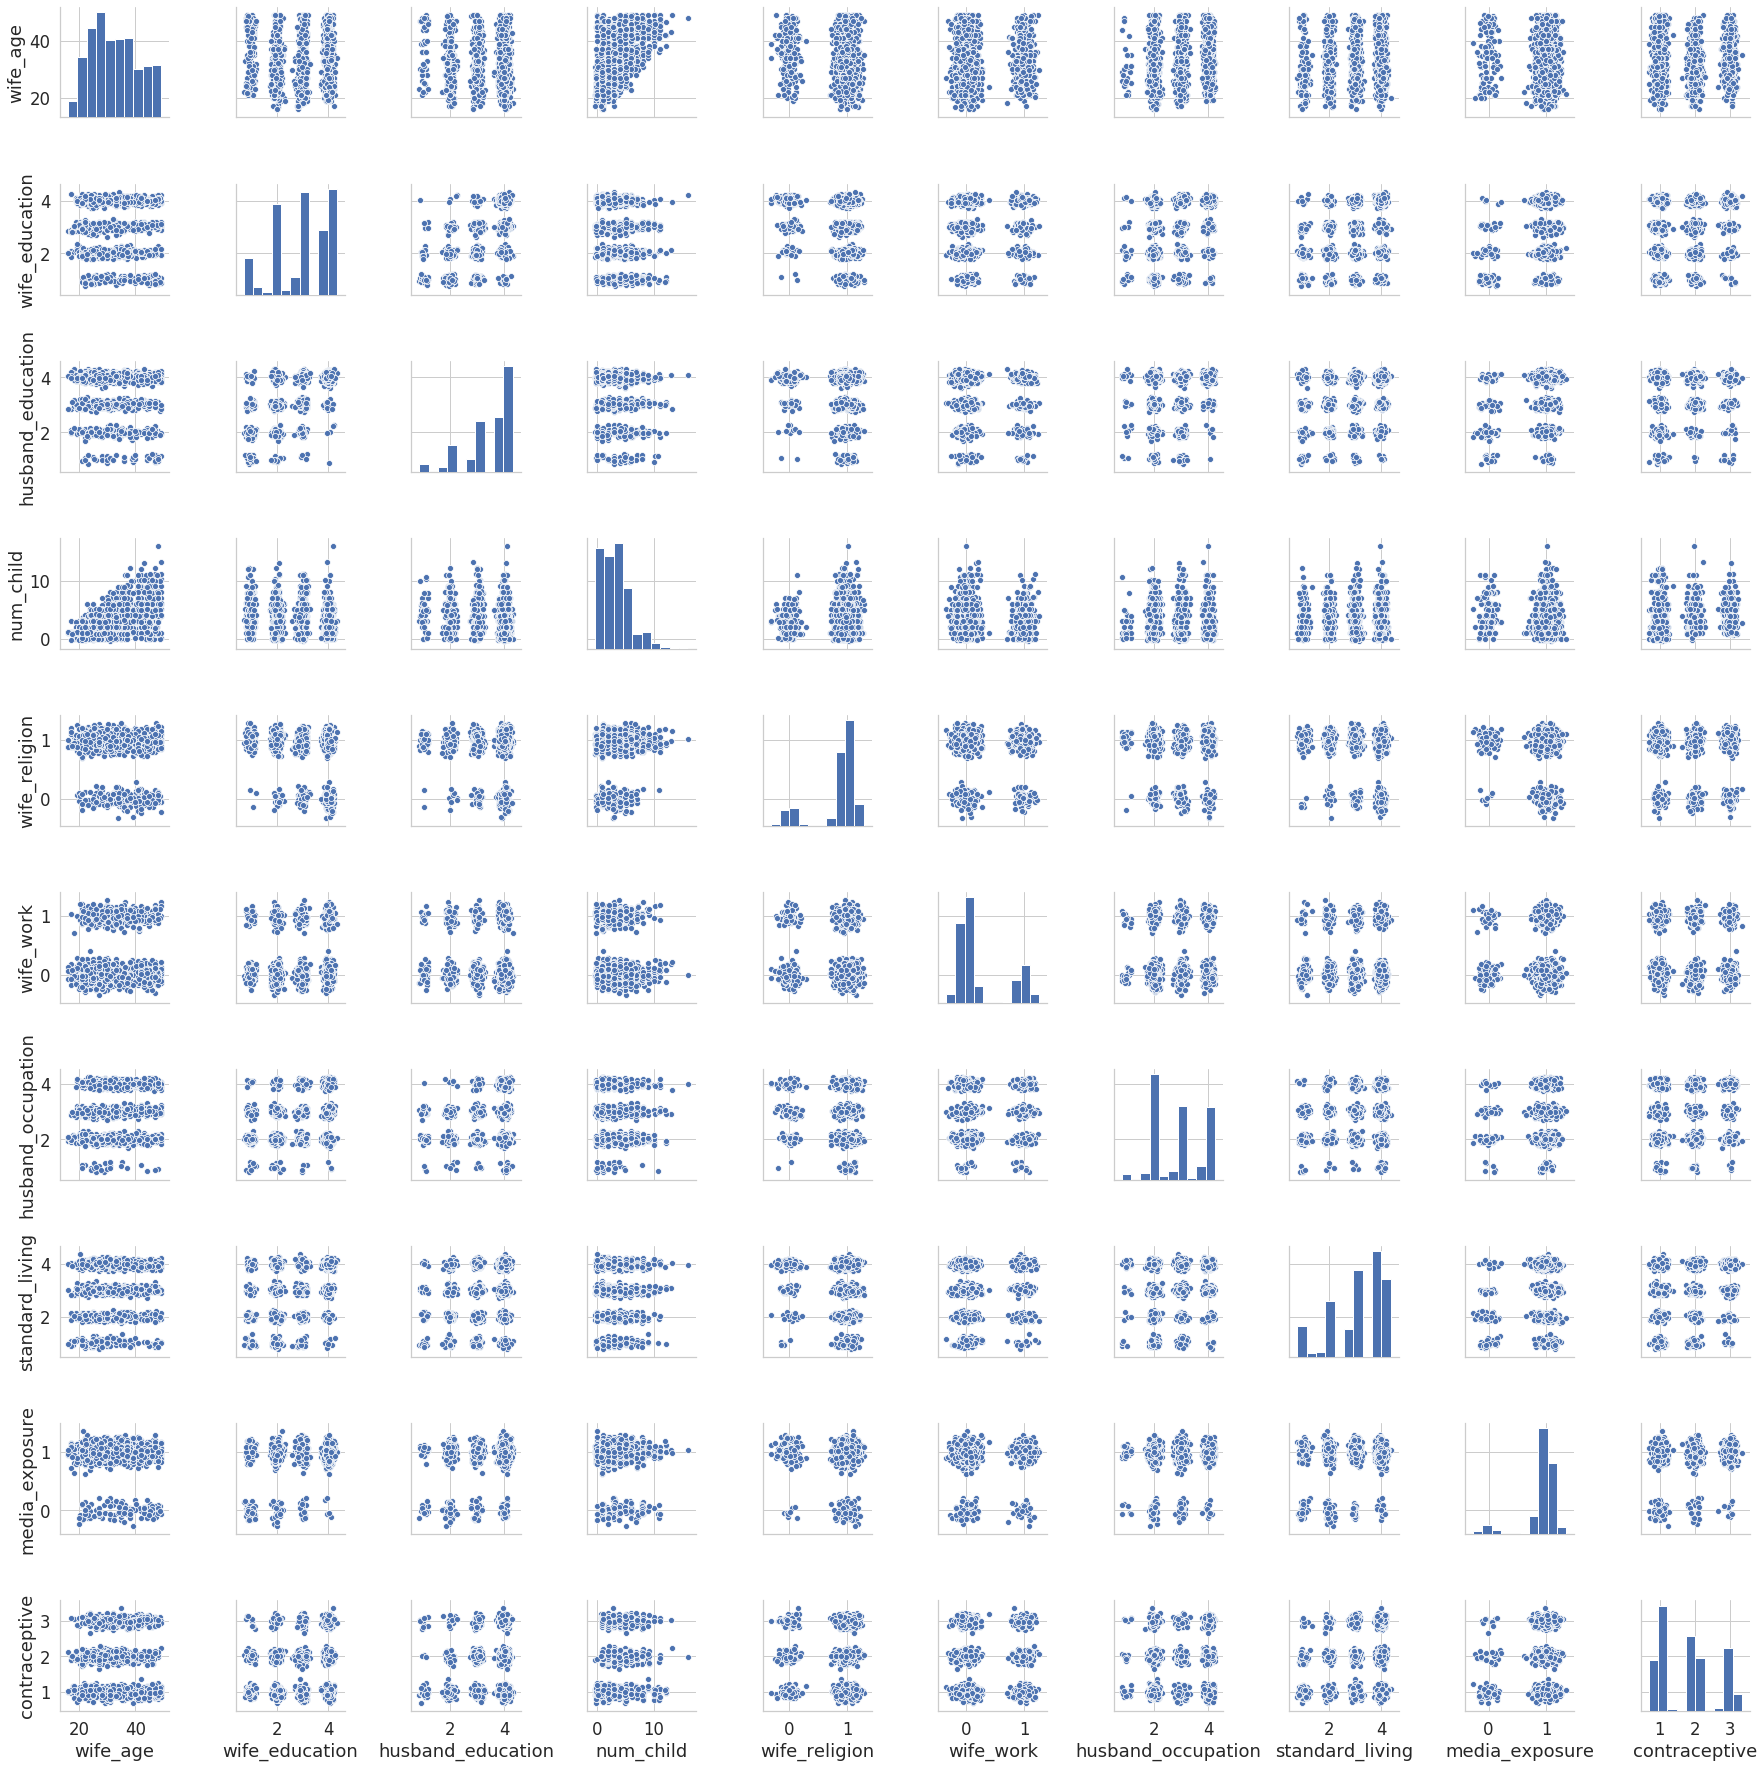

In [11]:
# Used original non-hot encoded dataset for clarity.

plt.figure(figsize = (20, 20))
sns.pairplot(contra_copy + np.random.normal(0, 0.1, size = (len(contra_copy), 10)))
plt.show();

Not a lot of direct information can be told from here. Some interesting trends to note:
1. Wife's age does make an impact on the number of children: older women naturally have more children. However, it appears that the type of contraceptive used is quite similar. 
2. Women below 20's appear to not use Contraceptive option 2 as much as option 1 or 3. It appears that older women tend to prefer contraceptive type 1 by a margin. 
3. It appears that more educated women tend to have better access to media in comparison to less educated women. 
4. Husband education appears more of an indicator of standard living than wife's education which may be because it is culturally normal for married women in Indonesia to not be working, hence not contributing as much to the household finance. 
5. There is a relatively positive correlation between level of wife and husband education. There also appears to a positive correlation between level of wife education and her husband's occupation.

## **EDA**

**Note**: Some EDA may use original dataset for the purposes of clarity. 

I. These EDAs investigate the general relationships between the **contraceptive methods** and certain features that we *expect* to have affected the decision such as **Standard of Living / Number of children / Wife's age / Wife's education levels**.

1. *How popular is each type of method in general?*


There are 629 women not using contraceptives.
There are 511 women using short_term contraceptives.
There are 333 women using long-term contraceptives.


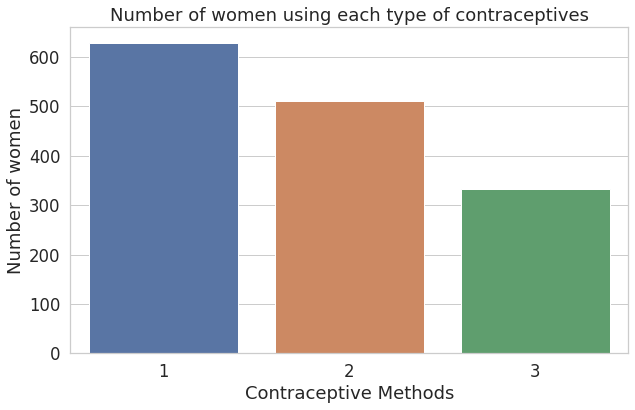

In [12]:
no_use = np.count_nonzero(contra['contraceptive']==1)
short_term = np.count_nonzero(contra['contraceptive']==2)
long_term = np.count_nonzero(contra['contraceptive']==3)

print("There are", no_use, "women not using contraceptives.")
print("There are", short_term, "women using short_term contraceptives.")
print("There are", long_term, "women using long-term contraceptives.")

plt.figure(figsize=(10,6))
sns.countplot(x='contraceptive',data=contra)
plt.xlabel("Contraceptive Methods")
plt.title("Number of women using each type of contraceptives")
plt.ylabel("Number of women")
plt.show();


2. *How popular is each method in each standard of living category?*

It appears that no-use is the most popular type of contraception across all living standards, however a greater proportion women with a higher standard of living prefer long-term contraceptives.




In [13]:
#Pivot table based on counts between contraceptions and quality of living
contra_labeled = contra_copy.copy(deep=True)
replace_val(contra_labeled, ["contraceptive"], [1, 2, 3], ["No-use", "Short-term", "Long-term"])
contra_QOL = contra_labeled[["standard_living", "contraceptive"]]

pivot_contra = contra_QOL.pivot_table(index = 'standard_living', columns = 'contraceptive', aggfunc='size')

#Percentage of popularity of the methods in each SOL
pivot_propSOL = pd.DataFrame(columns = ['Long-term', 'No-use', 'Short-term'], 
                             index = ['Low', 'Med-Low', 'Medium', 'High'])
pivot_propSOL.iloc[0] = pivot_contra.iloc[0].values/sum(pivot_contra.iloc[0].values)
pivot_propSOL.iloc[1] = pivot_contra.iloc[1].values/sum(pivot_contra.iloc[1].values)
pivot_propSOL.iloc[2] = pivot_contra.iloc[2].values/sum(pivot_contra.iloc[2].values)
pivot_propSOL.iloc[3] = pivot_contra.iloc[3].values/sum(pivot_contra.iloc[3].values)

pivot_contra, pivot_propSOL

(contraceptive    Long-term  No-use  Short-term
 standard_living                               
 1                        9      80          40
 2                       30     117          82
 3                       90     184         157
 4                      204     248         232,
          Long-term    No-use Short-term
 Low      0.0697674  0.620155   0.310078
 Med-Low   0.131004  0.510917   0.358079
 Medium    0.208817  0.426914   0.364269
 High      0.298246  0.362573   0.339181)

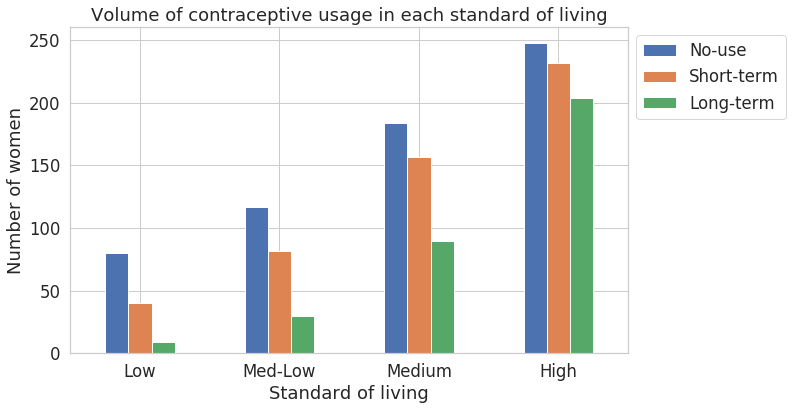

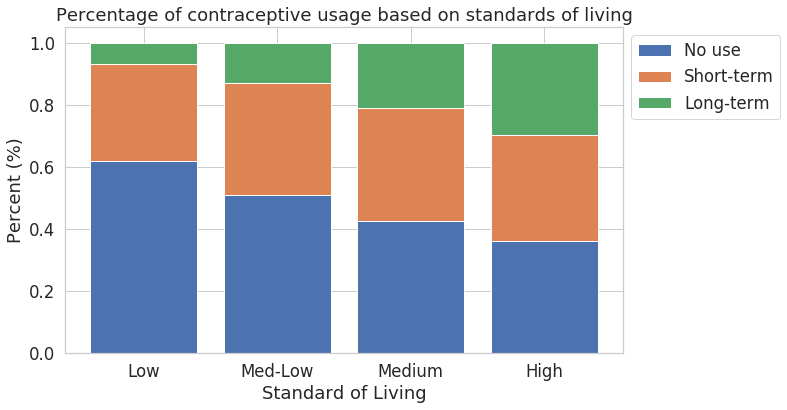

In [14]:
SOL = pivot_contra.iloc[:,[1, 2, 0]].plot(kind="bar", figsize=(10,6))
SOL.set_xticklabels(['Low', 'Med-Low', 'Medium', 'High'])
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.xticks(rotation=0)
plt.title("Volume of contraceptive usage in each standard of living")
plt.ylabel("Number of women")
plt.xlabel("Standard of living")

#----------

sd_liv = ['Low', 'Med-Low', 'Medium', 'High']
n = pivot_propSOL['No-use']
l = pivot_propSOL['Long-term']
s = pivot_propSOL['Short-term']

plt.figure(figsize=(10,6))
plt.bar(sd_liv, n, edgecolor='white', label="No use")
plt.bar(sd_liv, s, bottom=n, edgecolor='white', label="Short-term")
plt.bar(sd_liv, l, bottom=n+s, edgecolor='white', label="Long-term")
 
# plt.xticks(sd_liv)
plt.xlabel("Standard of Living")
plt.ylabel("Percent (%)")
plt.title("Percentage of contraceptive usage based on standards of living")
 
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.show();

3. *Is there a relationship between contraceptive method and number of children?*

Initially we assumed that non-users are more likely to have more children, but after looking at the boxplot, it turns out the relationship was the opposite. On average, non-users have 2 children while short term and long term contraceptive users more children in general.

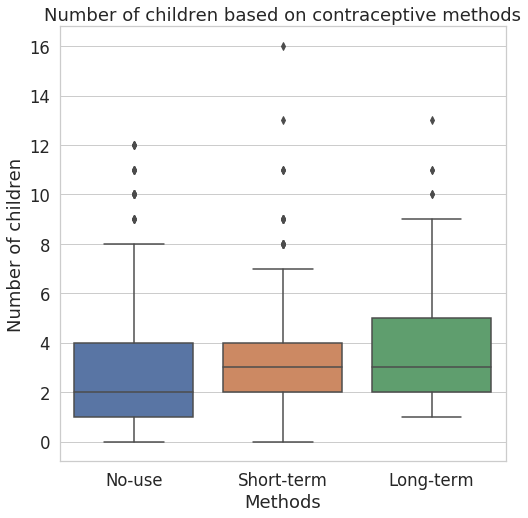

In [15]:
plt.figure(figsize=(8,8))
sns.boxplot(x=contra["contraceptive"], y=contra["num_child"]).set_xticklabels(['No-use', 'Short-term', 'Long-term'])
plt.title("Number of children based on contraceptive methods")
plt.xlabel("Methods")
plt.ylabel("Number of children")
plt.show();

4. *Is there a relationship between age and contraceptive method?*

Age is a huge factor when its comes to having children so we want to ensure that we take into account when we choose to age as a feature in our model.

From the graph, we can observe that older women tend to use long-term methods, while young moms are more likely to use short-term alternatives.

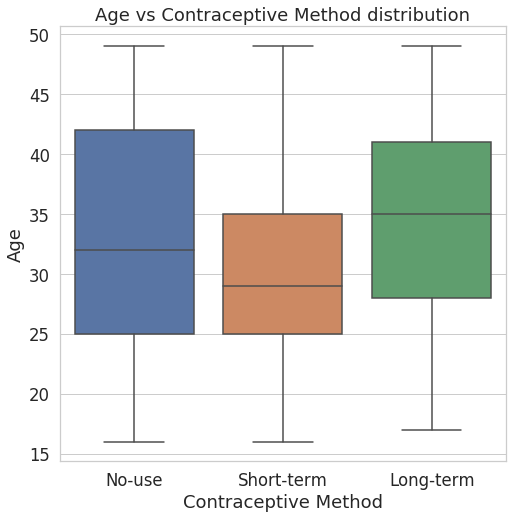

In [16]:
plt.figure(figsize=(8,8))
sns.boxplot(x=contra["contraceptive"], y=contra["wife_age"]).set_xticklabels(['No-use', 'Short-term', 'Long-term'])
plt.ylabel("Age")
plt.title("Age vs Contraceptive Method distribution")
plt.xlabel("Contraceptive Method")
plt.show();


5. *How are the method choices distributed among the wife's education levels?*

The ratios look very comparable to the ratios between methods and standard of living. This might indicate that these 2 features affect the choice of contraception similarly.

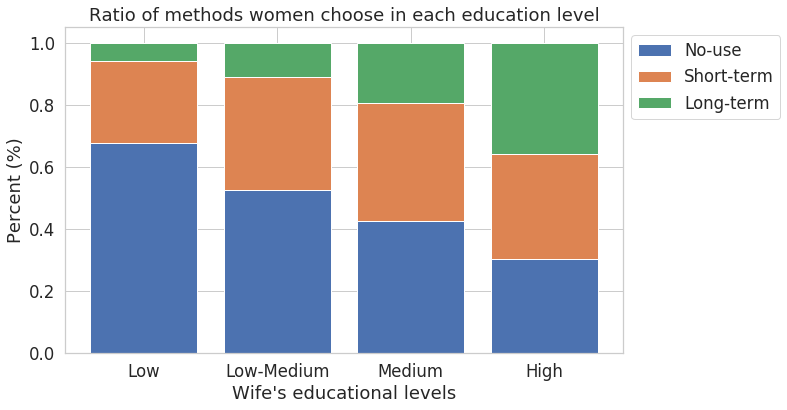

In [17]:
plt.figure(figsize=(10,6))

nouse_totals = [(sum(contra[contra["contraceptive"] == 1]["wife_education=Low"])/(contra[contra["wife_education=Low"]==1].shape[0])),
                (sum(contra[contra["contraceptive"] == 1]["wife_education=Low-Medium"])/(contra[contra["wife_education=Low-Medium"]==1].shape[0])),
                (sum(contra[contra["contraceptive"] == 1]["wife_education=Medium"])/(contra[contra["wife_education=Medium"]==1].shape[0])),
                (sum(contra[contra["contraceptive"] == 1]["wife_education=High"])/(contra[contra["wife_education=High"]==1].shape[0]))]

short_totals = [(sum(contra[contra["contraceptive"] == 2]["wife_education=Low"])/(contra[contra["wife_education=Low"]==1].shape[0])),
                (sum(contra[contra["contraceptive"] == 2]["wife_education=Low-Medium"])/(contra[contra["wife_education=Low-Medium"]==1].shape[0])),
                (sum(contra[contra["contraceptive"] == 2]["wife_education=Medium"])/(contra[contra["wife_education=Medium"]==1].shape[0])),
                (sum(contra[contra["contraceptive"] == 2]["wife_education=High"])/(contra[contra["wife_education=High"]==1].shape[0]))]

long_totals = [(sum(contra[contra["contraceptive"] == 3]["wife_education=Low"])/(contra[contra["wife_education=Low"]==1].shape[0])),
               (sum(contra[contra["contraceptive"] == 3]["wife_education=Low-Medium"])/(contra[contra["wife_education=Low-Medium"]==1].shape[0])),
               (sum(contra[contra["contraceptive"] == 3]["wife_education=Medium"])/(contra[contra["wife_education=Medium"]==1].shape[0])),
               (sum(contra[contra["contraceptive"] == 3]["wife_education=High"])/(contra[contra["wife_education=High"]==1].shape[0]))]

wife_education_nouse = plt.bar(["Low","Low-Medium","Medium","High"], nouse_totals)
wife_education_short = plt.bar(["Low","Low-Medium","Medium","High"], short_totals, bottom = np.array(nouse_totals))
wife_education_long = plt.bar(["Low","Low-Medium","Medium","High"], long_totals, bottom = np.array(nouse_totals) + np.array(short_totals))

plt.xlabel("Wife's educational levels")
plt.ylabel("Percent (%)")
plt.title("Ratio of methods women choose in each education level")
plt.legend((wife_education_nouse, wife_education_short, wife_education_long), ("No-use", "Short-term", "Long-term"),
           loc='upper left', bbox_to_anchor=(1,1))
plt.show();

II. This section of EDA considers whether the **working status and its  relationship with the woman's education** affects her contraceptive usage. 

We included this analysis so that we could analyze the potential confounding factor effects of a wife's working status vs her education in our models.

1. *Does contraceptive usage depend on whether the wife's working status?*

We hereby answer this question by comparing type of contraceptives by women who choose to work and not work. We found that women using long-term contraceptives are more likely to be working. 

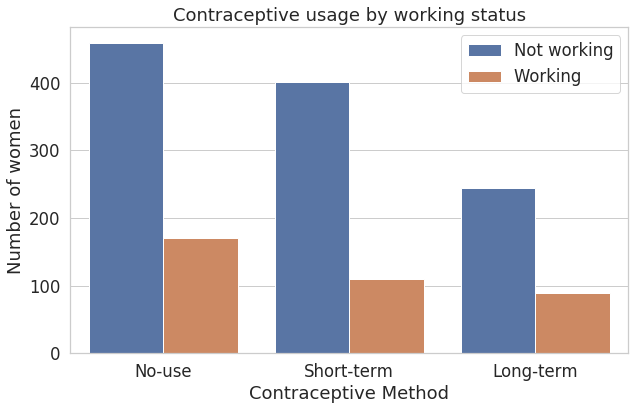

In [18]:
plt.figure(figsize=(10,6))
wrk_wife = sns.countplot(x='contraceptive',data=contra_copy,hue="wife_work")
wrk_wife.set_xticklabels(['No-use', 'Short-term', 'Long-term'])
plt.ylabel("Number of women")
plt.title("Contraceptive usage by working status")
plt.legend(("Not working", "Working"))
plt.xlabel("Contraceptive Method")
plt.show();

2. *Does a woman's education level determine the probability of her working?*

In general, the ratio of working women to non-working women across the education levels are almost uniform. Women with a higher degree of education are more likely to work by a margin. However, in general, only 20-30% of women in the datset work.

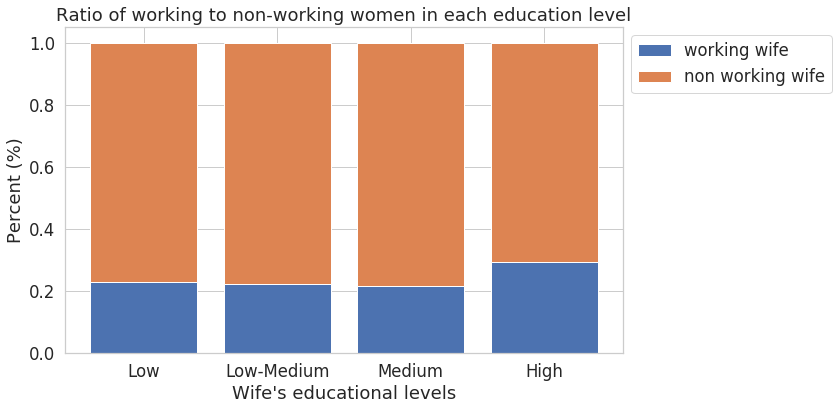

In [19]:
plt.figure(figsize=(10,6))

working_totals = [(sum(contra[contra["wife_work=Yes"] == 1]["wife_education=Low"])/(contra[contra["wife_education=Low"]==1].shape[0])), (sum(contra[contra["wife_work=Yes"] == 1]["wife_education=Low-Medium"])/(contra[contra["wife_education=Low-Medium"]==1].shape[0])), (sum(contra[contra["wife_work=Yes"] == 1]["wife_education=Medium"])/(contra[contra["wife_education=Medium"]==1].shape[0])), (sum(contra[contra["wife_work=Yes"] == 1]["wife_education=High"])/(contra[contra["wife_education=High"]==1].shape[0]))]
non_working_totals = [sum(contra[contra["wife_work=No"] == 1]["wife_education=Low"])/(contra[contra["wife_education=Low"]==1].shape[0]), sum(contra[contra["wife_work=No"] == 1]["wife_education=Low-Medium"])/(contra[contra["wife_education=Low-Medium"]==1].shape[0]), sum(contra[contra["wife_work=No"] == 1]["wife_education=Medium"])/(contra[contra["wife_education=Medium"]==1].shape[0]), sum(contra[contra["wife_work=No"] == 1]["wife_education=High"])/(contra[contra["wife_education=High"]==1].shape[0])]

wife_education_working = plt.bar(["Low","Low-Medium","Medium","High"], working_totals)
wife_education_non_working = plt.bar(["Low","Low-Medium","Medium","High"], non_working_totals, bottom = np.array(working_totals))
plt.xlabel("Wife's educational levels")
plt.ylabel("Percent (%)")
plt.title("Ratio of working to non-working women in each education level")
plt.legend((wife_education_working, wife_education_non_working), ("working wife", "non working wife"),
           loc='upper left', bbox_to_anchor=(1,1))
plt.show();

III. This next section of EDA considers the **relationship between husband occupation and wife working status**. 

Given that husband occupation has a stronger correlation with standard of living and socio-economic conditions, we want to see whether this effect is compounded by the wife's education level.

1. *What is the proportion of working to non-working status for husbands in each type of occupation?*

In agricultural group, a larger proportion of wives do not work. However, aside from that, there does not seem to be a trend. It is safe to assume that this will not pose as a potential confounding factor.

The proportion of working wives with husbands in professional are 0.2545871559633027
The proportion of working wives with husbands in sales are 0.27058823529411763
The proportion of working wives with husbands in manual are 0.22564102564102564
The proportion of working wives with husbands in agriculture are 0.4074074074074074


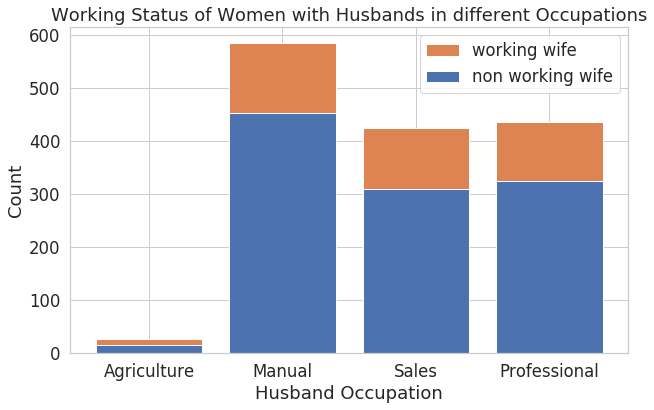

In [20]:
plt.figure(figsize=(10,6))

no_wife_working = [sum(contra[contra["wife_work=No"] == 1]["husband_occupation=Agriculture"]), sum(contra[contra["wife_work=No"] == 1]["husband_occupation=Manual"]), sum(contra[contra["wife_work=No"] == 1]["husband_occupation=Sales"]), sum(contra[contra["wife_work=No"] == 1]["husband_occupation=Professional"])]
wife_working = [sum(contra[contra["wife_work=Yes"] == 1]["husband_occupation=Agriculture"]), sum(contra[contra["wife_work=Yes"] == 1]["husband_occupation=Manual"]), sum(contra[contra["wife_work=Yes"] == 1]["husband_occupation=Sales"]), sum(contra[contra["wife_work=Yes"] == 1]["husband_occupation=Professional"])]

husband_occupation_types_no_wife_work = plt.bar(["Agriculture","Manual","Sales","Professional"], no_wife_working)
husband_occupation_types_wife_work = plt.bar(["Agriculture","Manual","Sales","Professional"], wife_working, bottom = np.array(no_wife_working))

plt.legend((husband_occupation_types_wife_work, husband_occupation_types_no_wife_work), ("working wife", "non working wife"))
plt.title("Working Status of Women with Husbands in different Occupations")
plt.xlabel("Husband Occupation")
plt.ylabel("Count")

print("The proportion of working wives with husbands in professional are", contra[(contra["wife_work=Yes"] == 1) & (contra["husband_occupation=Professional"] ==1)].shape[0]/contra[contra["husband_occupation=Professional"] ==1].shape[0])
print("The proportion of working wives with husbands in sales are", contra[(contra["wife_work=Yes"] == 1) & (contra["husband_occupation=Sales"] ==1)].shape[0]/contra[contra["husband_occupation=Sales"] ==1].shape[0])
print("The proportion of working wives with husbands in manual are", contra[(contra["wife_work=Yes"] == 1) & (contra["husband_occupation=Manual"] ==1)].shape[0]/contra[contra["husband_occupation=Manual"] ==1].shape[0])
print("The proportion of working wives with husbands in agriculture are", contra[(contra["wife_work=Yes"] == 1) & (contra["husband_occupation=Agriculture"] ==1)].shape[0]/contra[contra["husband_occupation=Agriculture"] ==1].shape[0])


plt.show();

2. *Is there  relationship between the wife's education level and her husband's occupation?*

Women with higher education are more likely to have husbands in white collar jobs. It appears there is a strong relationship between wife education and husband occupation.
Higher education levels tend to correlate with occupations with higher salaries and thus higher standard of living. Likewise, lower education levels tend to have husband occupations with lower salaries.

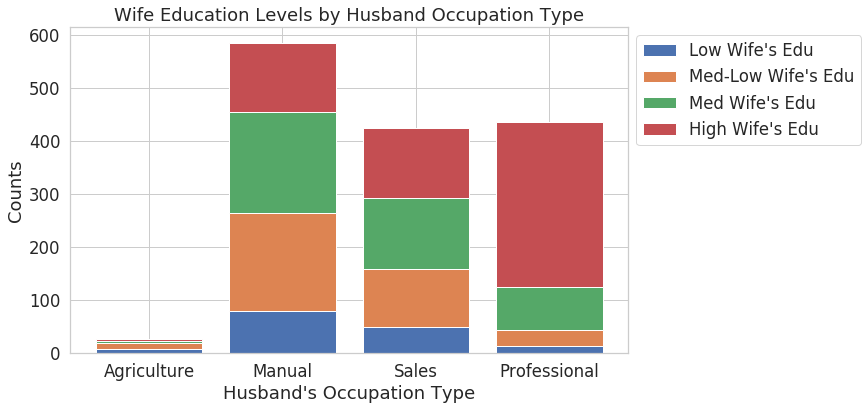

In [21]:
plt.figure(figsize=(10,6))

occ_wife_ed1= [sum(contra[contra["wife_education=Low"] == 1]["husband_occupation=Agriculture"]), sum(contra[contra["wife_education=Low"] == 1]["husband_occupation=Manual"]), sum(contra[contra["wife_education=Low"] == 1]["husband_occupation=Sales"]), sum(contra[contra["wife_education=Low"] == 1]["husband_occupation=Professional"])]
occ_wife_ed2= [sum(contra[contra["wife_education=Low-Medium"] == 1]["husband_occupation=Agriculture"]), sum(contra[contra["wife_education=Low-Medium"] == 1]["husband_occupation=Manual"]), sum(contra[contra["wife_education=Low-Medium"] == 1]["husband_occupation=Sales"]), sum(contra[contra["wife_education=Low-Medium"] == 1]["husband_occupation=Professional"])]
occ_wife_ed3 = [sum(contra[contra["wife_education=Medium"] == 1]["husband_occupation=Agriculture"]), sum(contra[contra["wife_education=Medium"] == 1]["husband_occupation=Manual"]), sum(contra[contra["wife_education=Medium"] == 1]["husband_occupation=Sales"]), sum(contra[contra["wife_education=Medium"] == 1]["husband_occupation=Professional"])]
occ_wife_ed4 = [sum(contra[contra["wife_education=High"] == 1]["husband_occupation=Agriculture"]), sum(contra[contra["wife_education=High"] == 1]["husband_occupation=Manual"]), sum(contra[contra["wife_education=High"] == 1]["husband_occupation=Sales"]), sum(contra[contra["wife_education=High"] == 1]["husband_occupation=Professional"])]

husband_occ_by_wife_ed1 = plt.bar(["Agriculture","Manual","Sales","Professional"], occ_wife_ed1)
husband_occ_by_wife_ed2 = plt.bar(["Agriculture","Manual","Sales","Professional"], occ_wife_ed2, bottom = np.array(occ_wife_ed1))
husband_occ_by_wife_ed3 = plt.bar(["Agriculture","Manual","Sales","Professional"], occ_wife_ed3, bottom = np.array(occ_wife_ed1) + np.array(occ_wife_ed2))
husband_occ_by_wife_ed4 = plt.bar(["Agriculture","Manual","Sales","Professional"], occ_wife_ed4, bottom = np.array(occ_wife_ed1) + np.array(occ_wife_ed2) + np.array(occ_wife_ed3))

plt.legend((husband_occ_by_wife_ed1, husband_occ_by_wife_ed2, husband_occ_by_wife_ed3, husband_occ_by_wife_ed4), 
           ("Low Wife's Edu", "Med-Low Wife's Edu", "Med Wife's Edu", "High Wife's Edu"),
           loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.xlabel("Husband's Occupation Type")
plt.ylabel("Counts")
plt.title("Wife Education Levels by Husband Occupation Type")
plt.show();

3. *Is there a relationship between a wife and husband's education?*

There is a pretty clear relationship between wife and husband education. Highly education wives tend to have highly education husbands and vice versa. 
This is likely to create synergies in building a higher standard of living.

The proportion of highly educated husbands with highly educated wives is 0.6051167964404894


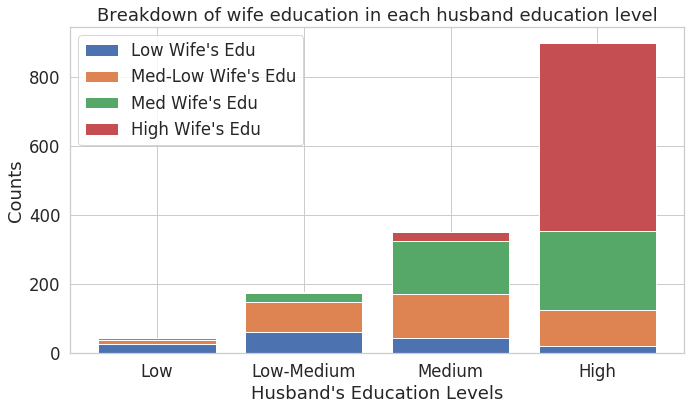

In [22]:
 plt.figure(figsize=(11,6))

wife_ed1 = [sum(contra[contra["wife_education=Low"] == 1]["husband_education=Low"]), sum(contra[contra["wife_education=Low"] == 1]["husband_education=Low-Medium"]), sum(contra[contra["wife_education=Low"] == 1]["husband_education=Medium"]), sum(contra[contra["wife_education=Low"] == 1]["husband_education=High"])]
wife_ed2 = [sum(contra[contra["wife_education=Low-Medium"] == 1]["husband_education=Low"]), sum(contra[contra["wife_education=Low-Medium"] == 1]["husband_education=Low-Medium"]), sum(contra[contra["wife_education=Low-Medium"] == 1]["husband_education=Medium"]), sum(contra[contra["wife_education=Low-Medium"] == 1]["husband_education=High"])]
wife_ed3 = [sum(contra[contra["wife_education=Medium"] == 1]["husband_education=Low"]), sum(contra[contra["wife_education=Medium"] == 1]["husband_education=Low-Medium"]), sum(contra[contra["wife_education=Medium"] == 1]["husband_education=Medium"]), sum(contra[contra["wife_education=Medium"] == 1]["husband_education=High"])]
wife_ed4 = [sum(contra[contra["wife_education=High"] == 1]["husband_education=Low"]), sum(contra[contra["wife_education=High"] == 1]["husband_education=Low-Medium"]), sum(contra[contra["wife_education=High"] == 1]["husband_education=Medium"]), sum(contra[contra["wife_education=High"] == 1]["husband_education=High"])]

husband_education_by_wife_ed1 = plt.bar(["Low","Low-Medium","Medium","High"], wife_ed1)
husband_education_by_wife_ed2 = plt.bar(["Low","Low-Medium","Medium","High"], wife_ed2, bottom = np.array(wife_ed1))
husband_education_by_wife_ed3 = plt.bar(["Low","Low-Medium","Medium","High"], wife_ed3, bottom = np.array(wife_ed1) + np.array(wife_ed2))
husband_education_by_wife_ed4 = plt.bar(["Low","Low-Medium","Medium","High"], wife_ed4, bottom = np.array(wife_ed1) + np.array(wife_ed2) + np.array(wife_ed3))

plt.legend((husband_education_by_wife_ed1, husband_education_by_wife_ed2, husband_education_by_wife_ed3, husband_education_by_wife_ed4), 
           ("Low Wife's Edu", "Med-Low Wife's Edu", "Med Wife's Edu", "High Wife's Edu"))
plt.ylabel("Counts")
plt.xlabel("Husband's Education Levels")
plt.title("Breakdown of wife education in each husband education level")


print("The proportion of highly educated husbands with highly educated wives is", contra[(contra["wife_education=High"] == 1) & (contra["husband_education=High"] ==1)].shape[0]/contra[contra["husband_education=High"] ==1].shape[0])
plt.show();


4. *What is the household education effect on standard of living?*

Household education is the mean of husband and wife's education. We note that this may be skewed by couples with highly disparate education levels. 
Nonetheless, we can see a trend where a combined higher education level tends to result in a higher standard of living.

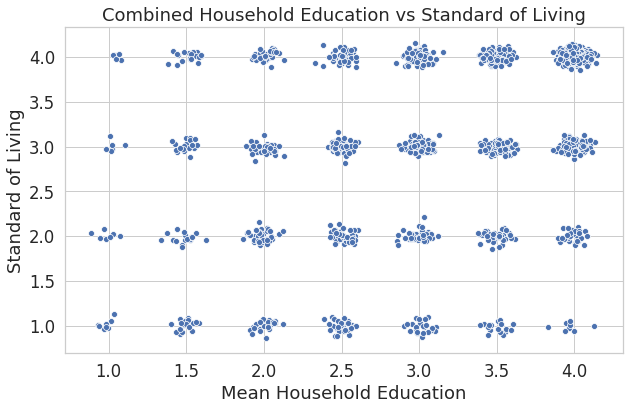

In [23]:
plt.figure(figsize=(10, 6))
contra_copy["household_education"] = (contra_copy["husband_education"] + contra_copy["wife_education"])/2
combined_QOL = sns.scatterplot(contra_copy["household_education"] + np.random.normal(0, 0.05, size = len(contra_copy)), contra_copy["standard_living"] + np.random.normal(0, 0.05, size = len(contra_copy)))
plt.xlabel("Mean Household Education")
plt.ylabel("Standard of Living")
plt.title("Combined Household Education vs Standard of Living")
plt.show();

### **PCA**


Age takes up a large portion of the variance so we tried PCA without it to guage which socio economic features form PCs to generate higher variance.

Variances with all features: [0.89 0.05 0.03 0.01 0.01 0.01 0.   0.   0.   0.   0.  ]


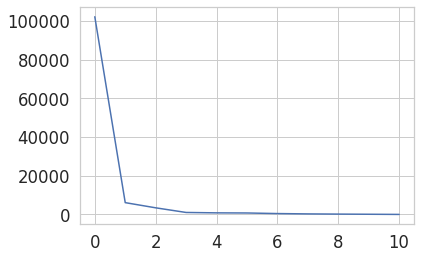

In [24]:
def compute_rank_k_approximation(data, k):
    u, s, vt = np.linalg.svd(data, full_matrices = False)
    return pd.DataFrame(u[:, 0:k] @ np.diag(s[0:k]) @ vt[0:k, :], columns = data.columns)

contra_centered = contra_copy - np.mean(contra_copy, axis = 0)

u_full, s_full, vt_full = np.linalg.svd(contra_centered, full_matrices = False)
variances_with_all_features = np.round(s_full**2 / sum(s_full**2), 2)
print('Variances with all features:', variances_with_all_features)

plt.plot(s_full**2)
plt.show();

Variances without age features: [0.54 0.23 0.07 0.05 0.05 0.03 0.02 0.01 0.01 0.  ]


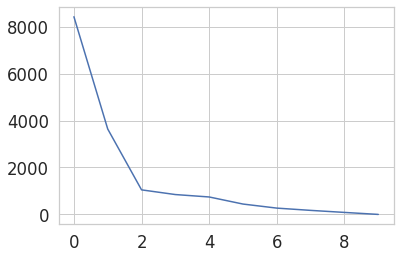

In [25]:
u, s, vt = np.linalg.svd(contra_centered.iloc[:, 1:], full_matrices = False)
variances_without_age_features = np.round(s**2 / sum(s**2), 2)
print('Variances without age features:', variances_without_age_features)
plt.plot(s**2)
plt.show();

It looks like the first three-four principle components make up a large amount of the variance.

In [26]:
#Rank 3 approximations provides a pretty close re-creation of the original dataset.
contra_rank_3_approximation = compute_rank_k_approximation(contra_centered, 3) +  np.mean(contra_copy, axis = 0)
contra_rank_3_approximation = np.round(contra_rank_3_approximation, 0)
contra_rank_3_approximation.head(5)


,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive,household_education
0,24.0,2.0,3.0,3.0,1.0,0.0,2.0,3.0,1.0,2.0,3.0
1,45.0,2.0,2.0,10.0,1.0,0.0,3.0,3.0,1.0,2.0,2.0
2,43.0,2.0,3.0,7.0,1.0,0.0,3.0,3.0,1.0,2.0,2.0
3,42.0,2.0,3.0,9.0,1.0,0.0,3.0,3.0,1.0,2.0,2.0
4,36.0,2.0,3.0,8.0,1.0,0.0,3.0,3.0,1.0,2.0,3.0


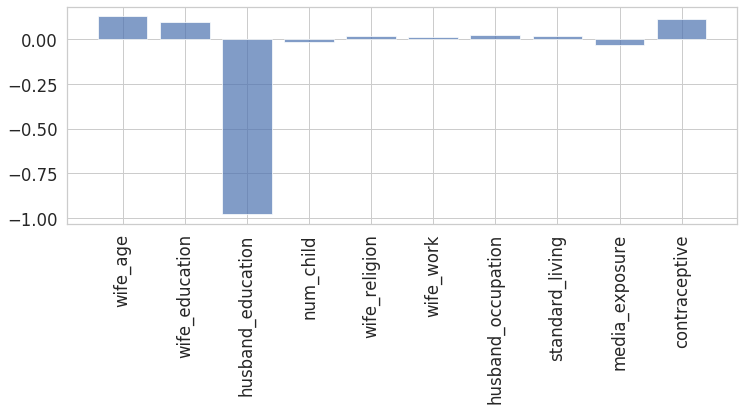

In [27]:
#Plotting out which features have the greatest weighting on the PCs. 
def pc_weighting(columns, vt, k):
    plt.bar(columns, vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90);
  
col_names = contra_copy.columns
col_names = col_names[:-1]

with plt.rc_context({"figure.figsize": (12, 4)}):
  pc_weighting(col_names, vt, 0);

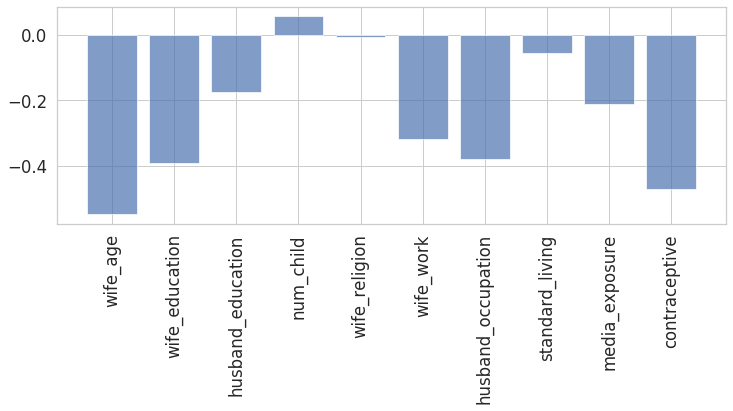

In [28]:
with plt.rc_context({"figure.figsize": (12, 4)}):
  pc_weighting(col_names, vt, 1);

From the first three PC's, we can see that the most heavily weighted features (aside from contraceptive), are wife_age, wife_education, husband_education and husband_occupation. The features with the smallest absolute weightings are num_child and wife_religion.'

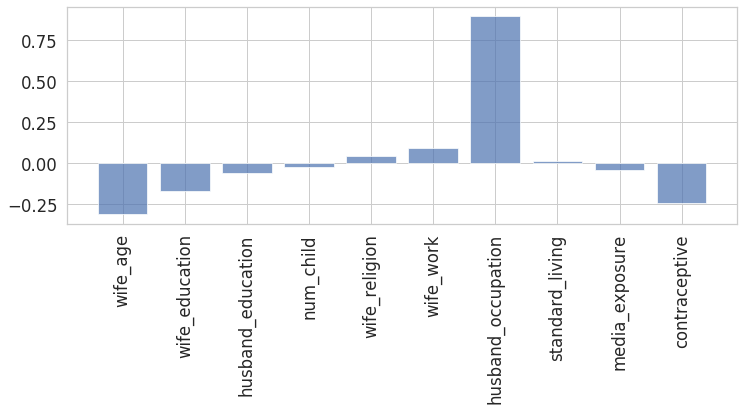

In [29]:
with plt.rc_context({"figure.figsize": (12, 4)}):
  pc_weighting(col_names, vt, 2);

From the first three PC's, we can see that the most heavily weighted features (aside from contraceptive), are wife_age, wife_education, husband_education and husband_occupation. The features with the smallest absolute weightings are num_child and wife_religion.'

# **NORMALIZING**

In [30]:
def df_normalize(df, col):
  #dF: dataframe / col: list of column
  df[col] = (df[col] - df[col].mean()) / df[col].std()


df_normalize(contra, ["wife_age"])
df_normalize(contra, ["num_child"])
contra.head(5)

,wife_age,num_child,contraceptive,husband_education=High,husband_education=Low,husband_education=Low-Medium,husband_education=Medium,husband_occupation=Agriculture,husband_occupation=Manual,husband_occupation=Professional,...,standard_living=Low-Medium,standard_living=Medium,wife_education=High,wife_education=Low,wife_education=Low-Medium,wife_education=Medium,wife_religion=Islam,wife_religion=Non-Islam,wife_work=No,wife_work=Yes
0,-1.037815,-0.110819,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.514680,2.857108,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.271585,1.585139,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.150038,2.433118,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.420754,2.009129,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


# **OUTLIER REMOVAL**

Based on the EDAs above, we observe that there is an outlier of a household with 16 children (5.401045 after normalizing). Worrying that this outlier might affect the models' accuracy, we decide to create a new dataframe without it to test whether the accuracy is improved.

In [31]:
contra.sort_values(by="num_child", ascending = False).head(5)

,wife_age,num_child,contraceptive,husband_education=High,husband_education=Low,husband_education=Low-Medium,husband_education=Medium,husband_occupation=Agriculture,husband_occupation=Manual,husband_occupation=Professional,...,standard_living=Low-Medium,standard_living=Medium,wife_education=High,wife_education=Low,wife_education=Low-Medium,wife_education=Medium,wife_religion=Islam,wife_religion=Non-Islam,wife_work=No,wife_work=Yes
653,1.879322,5.401045,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
675,2.000869,4.129076,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
519,1.271585,4.129076,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1013,0.663848,3.705087,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1142,1.150038,3.705087,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [32]:
contra.drop(contra[contra['num_child'] > 5].index, inplace= True)
contra.head(5)

,wife_age,num_child,contraceptive,husband_education=High,husband_education=Low,husband_education=Low-Medium,husband_education=Medium,husband_occupation=Agriculture,husband_occupation=Manual,husband_occupation=Professional,...,standard_living=Low-Medium,standard_living=Medium,wife_education=High,wife_education=Low,wife_education=Low-Medium,wife_education=Medium,wife_religion=Islam,wife_religion=Non-Islam,wife_work=No,wife_work=Yes
0,-1.037815,-0.110819,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.514680,2.857108,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.271585,1.585139,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.150038,2.433118,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.420754,2.009129,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


# **MODEL**

In [33]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [34]:
#Splitting the dataset into train set and test set

X = contra.drop('contraceptive', axis=1)
Y = contra['contraceptive']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1104, 24) (368, 24) (1104,) (368,)


Model 1: **Logistic Regression**

**Base Model**

In [35]:
#Logistic Regression with numerical features

X_base= contra[["wife_age", "num_child"]]

lr_base = LogisticRegression(random_state=42, solver='lbfgs', multi_class = 'auto', max_iter = 5000, dual=False)
lr_base.fit(X_base, Y)

accuracy_base = lr_base.score(X_base, Y)
accuracy_cvbase = cross_val_score(lr_base, X_base, Y, scoring='accuracy', cv = 10)

print("Accuracy of Model:", accuracy_base)
print("Accuracy of Model with Cross Validation:",accuracy_cvbase.mean())


Accuracy of Model: 0.47690217391304346
Accuracy of Model with Cross Validation: 0.47286700315076047


**Multiclass Logistic Regression**

There are 3 classes of contraceptive methods (no-use / short-term / long-term) to classify using given features. This is a **multiclass classification** problem. We are using the ***one-versus-rest*** approach where the multiclass prediction problem is divided into separate binary prediction problems.

In [36]:
#Multiple Logistic Regression one-vs-rest, Train-Test Split with all features

lr = LogisticRegression(multi_class = 'ovr', solver='lbfgs', random_state=42, max_iter = 5000, dual=False)
lr.fit(X_train, Y_train)

accuracy_spt = lr.score(X_train, Y_train)
accuracy_cvspt = cross_val_score(lr, X_train, Y_train, scoring='accuracy', cv = 10)

print("Train Accuracy of Model:", accuracy_spt)
print("Accuracy of Model with Cross Validation:",accuracy_cvspt.mean())

Train Accuracy of Model: 0.5153985507246377
Accuracy of Model with Cross Validation: 0.5035549143806024


**Using different Features**

In [37]:
#Find the heavily weighted features

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=10, random_state=42)
model.fit(X_train, Y_train)

labels = X_train.columns.values.tolist()
feature_importances = model.feature_importances_

importance = pd.DataFrame({
    'features': labels,
    'importance': feature_importances})
importance.sort_values(by='importance', ascending=False, inplace=True)
features = importance[importance['importance'] > 0.02]['features'].values.tolist()

In [38]:
#Multiple Logistic Regression, Train/Test split with important features

X_fea = contra[features]

X_train_f, X_test_f, Y_train, Y_test = train_test_split(X_fea, Y, test_size=0.25, random_state=42)

lr = LogisticRegression(multi_class = 'ovr', solver='lbfgs', random_state=42, max_iter = 5000, dual=False)
lr.fit(X_train_f, Y_train)

accuracy_fea = lr.score(X_train_f, Y_train)
accuracy_cvfea = cross_val_score(lr, X_train_f, Y_train, scoring='accuracy', cv = 10)

print("Train Accuracy of Model:", accuracy_fea)
print("Accuracy of Model with Cross Validation:", accuracy_cvfea.mean())

Train Accuracy of Model: 0.5036231884057971
Accuracy of Model with Cross Validation: 0.4963396674405849


In [39]:
#Multiple Logistic Regression, Train/Test Split with highly correlated features

X_corrfea = contra[corr_features.index]
X_train_c, X_test_c, Y_train, Y_test = train_test_split(X_corrfea, Y, test_size=0.25, random_state=42)

lr = LogisticRegression(multi_class = 'ovr', solver='lbfgs', random_state=42, max_iter = 5000, dual=False)
lr.fit(X_train_c, Y_train)

accuracy_corr = lr.score(X_train_c, Y_train)
accuracy_cvcorr = cross_val_score(lr, X_train_c, Y_train, scoring='accuracy', cv = 10)

print("Train Accuracy of Model:", accuracy_corr)
print("Accuracy of Model with Cross Validation:",accuracy_cvcorr.mean())

Train Accuracy of Model: 0.47101449275362317
Accuracy of Model with Cross Validation: 0.46653517570948766


From the results above, we can see that using MLR on all features yields the best result among the LR models. The **model improvement score** is 0.03 or **3%**.

Model 2: **Decision Tree**



**Base Model**

In [40]:
from sklearn import tree
from sklearn.metrics import accuracy_score

dt_model = tree.DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, Y_train)

accuracy_tree = accuracy_score(dt_model.predict(X_train), Y_train)
accuracy_cvtree = cross_val_score(dt_model, X_train, Y_train, scoring='accuracy', cv = 10)

print("Train Accuracy of Model:", accuracy_tree)
print("Accuracy of Model with Cross Validation:",accuracy_cvtree.mean())

Train Accuracy of Model: 0.9682971014492754
Accuracy of Model with Cross Validation: 0.4611626806122219


**Tuning Hyperparameters**

In [41]:
#Finding the best parameters for the model using criterion, max_depth and min_samples_leaf
from sklearn.model_selection import GridSearchCV

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(1, 6)
}

dt_model = tree.DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator = dt_model, param_grid = parameters, 
                          cv = 10, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    4.9s finished


{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2}

In [42]:
#Hyperparameter tuning the model #1

tuneddt_model = tree.DecisionTreeClassifier(random_state=42, criterion= 'gini', max_depth= 4, min_samples_leaf= 2)

tuneddt_model.fit(X_train, Y_train)

accuracy_tunedtree1 = accuracy_score(tuneddt_model.predict(X_train), Y_train)
accuracy_cvtunedtree1 = cross_val_score(tuneddt_model, X_train, Y_train, scoring='accuracy', cv = 10)

print("Train Accuracy of Model:", accuracy_tunedtree1)
print("Accuracy of Model with Cross Validation:", accuracy_cvtunedtree1.mean())

Train Accuracy of Model: 0.5670289855072463
Accuracy of Model with Cross Validation: 0.5597319838604242


In [43]:
#Finding the best parameters for the model using criterion and max_depth

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 15)
}

dt_model = tree.DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator = dt_model, param_grid = parameters, 
                          cv = 10, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, Y_train)
grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.8s finished


{'criterion': 'gini', 'max_depth': 4}

In [44]:
#Hyperparameter tuning the model #2

tuneddt_model = tree.DecisionTreeClassifier(random_state=42, criterion= 'gini', max_depth= 4)

tuneddt_model.fit(X_train, Y_train)

accuracy_tunedtree2 = accuracy_score(tuneddt_model.predict(X_train), Y_train)

accuracy_cvtunedtree2 = cross_val_score(tuneddt_model, X_train, Y_train, scoring='accuracy', cv = 10)

print("Train Accuracy of Model:", accuracy_tunedtree2)
print("Accuracy of Model with Cross Validation:", accuracy_cvtunedtree2.mean())

Train Accuracy of Model: 0.5688405797101449
Accuracy of Model with Cross Validation: 0.5579301820586224


As expected, changing the **depth of tree** not only helps us improve the CV accuracy score of the models, but also takes care of the overfitting problem that we have in the base model. 2 tuned models both yield better results, with the first one having only slightly better score since we also tuned the min_samples_leaf parameter. The **model improvement score** is 0.099 or **9.9%**

Model 3: **Random Forest**

**Base Model**

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, Y_train)

accuracy_rf = rf_model.score(X_train, Y_train)
accuracy_cvrf = cross_val_score(rf_model, X_train, Y_train, scoring='accuracy', cv = 10)

print("Train Accuracy of Model:", accuracy_rf)
print("Accuracy of Model with Cross Validation:",accuracy_cvrf.mean())

/srv/app/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Train Accuracy of Model: 0.9393305439330544
Accuracy of Model with Cross Validation: 0.5042467785910267


**Tuning Hyperparameters**

In [46]:
#Finding the best parameters for the model using criterion, 
#max_depth, min_sampleS_leaf, min_samples_split and n_estimators

rf_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(9, 14),
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': np.arange(10, 31, 10)
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator = rf_model, param_grid = rf_parameters, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   13.2s finished
/srv/app/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

In [47]:
#hyperparameter tuning Random Forest #1

tunedrf_model = RandomForestClassifier(random_state=42, criterion = 'gini', max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=30)
tunedrf_model.fit(X_train, Y_train)

accuracy_tunedrf1 = tunedrf_model.score(X_train, Y_train)
accuracy_cvtunedrf1 = cross_val_score(tunedrf_model, X_train, Y_train, scoring='accuracy', cv = 5)

print("Train Accuracy of Model:", accuracy_tunedrf1)
print("Accuracy of Model with Cross Validation:",accuracy_cvtunedrf1.mean())

Train Accuracy of Model: 0.7290794979079498
Accuracy of Model with Cross Validation: 0.5457675438596491


In [48]:
#Finding the best parameters for the model using criterion, max_depth and n_estimators
rf_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 20),
    'n_estimators': np.arange(10, 100, 10)
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator = rf_model, param_grid = rf_parameters, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1695 out of 1710 | elapsed:   34.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1710 out of 1710 | elapsed:   34.6s finished
/srv/app/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 90}

In [49]:
#hyperparameter tuning Random Forest #2

tunedrf_model = RandomForestClassifier(random_state=42, criterion = 'gini', max_depth=6, n_estimators=90)
tunedrf_model.fit(X_train, Y_train)

Y_hat = tunedrf_model.predict(X_test)

accuracy_tunedrf2 = tunedrf_model.score(X_train, Y_train)
accuracy_cvtunedrf2 = cross_val_score(tunedrf_model, X_train, Y_train, scoring='accuracy', cv = 5)

print("Train Accuracy of Model:", accuracy_tunedrf2)
print("Accuracy of Model with Cross Validation:",accuracy_cvtunedrf2.mean())

Train Accuracy of Model: 0.6589958158995816
Accuracy of Model with Cross Validation: 0.5510526315789473


Same as the Decision Tree, fine-tuning the max_depth and n_estimators parameters results in better Random Forest models and higher CV scores. However, the training accuracy is still a little high, indicating that we might have slightly overfit the models. The **model improvement score** is 0.04 or **4%**

# **COMPARING MODELS**

To choose the best model for our dataset, we compare the 10 models above using CV score as the main criteria.

In [50]:
scores = pd.DataFrame({
    'Model': ["Base", 
              "Multiclass LR", "Multiclass LR Important Features", "Multiclass LR Correlated Features",
              "Decision Tree", "Hyperparameter Tuned Tree 1", "Hyperparameter Tuned Tree 2",
              "Random Forest", "Hyperparameter Tuned Forest 1", "Hyperparameter Tuned Forest 2"],
    "Train Score": [accuracy_base, 
                    accuracy_spt, accuracy_fea, accuracy_corr,
                    accuracy_tree, accuracy_tunedtree1, accuracy_tunedtree2,
                    accuracy_rf, accuracy_tunedrf1, accuracy_tunedrf2],
    "CV 10-fold Score": [accuracy_cvbase.mean(),
                         accuracy_cvspt.mean(), accuracy_cvfea.mean(), accuracy_cvcorr.mean(),
                         accuracy_cvtree.mean(), accuracy_cvtunedtree1.mean(), accuracy_cvtunedtree2.mean(),
                         accuracy_cvrf.mean(), accuracy_cvtunedrf1.mean(), accuracy_cvtunedrf2.mean()]
})
scores.sort_values(by='CV 10-fold Score', ascending=False)

,Model,Train Score,CV 10-fold Score
5,Hyperparameter Tuned Tree 1,0.567029,0.559732
6,Hyperparameter Tuned Tree 2,0.568841,0.557930
9,Hyperparameter Tuned Forest 2,0.658996,0.551053
8,Hyperparameter Tuned Forest 1,0.729079,0.545768
7,Random Forest,0.939331,0.504247
1,Multiclass LR,0.515399,0.503555
2,Multiclass LR Important Features,0.503623,0.496340
0,Base,0.476902,0.472867
3,Multiclass LR Correlated Features,0.471014,0.466535
4,Decision Tree,0.968297,0.461163


We decide to move forward with the **Hyperparameter Tuned Tree 1** as our final model because it has proven to give good CV score without the cost of overfitting.

# **Final Model**

Finally, we will use the model we choose above to test on the test set. 

We expect that the test score will be close to our CV 10-fold score, give or take 2%.

In [51]:
#Final Model using tuned Decision Tree

final_model = tree.DecisionTreeClassifier(random_state=42, criterion= 'gini', max_depth= 4, min_samples_leaf= 2)
final_model.fit(X_train, Y_train)

train_accuracy_final = accuracy_score(final_model.predict(X_train), Y_train)
test_accuracy_final = accuracy_score(final_model.predict(X_test), Y_test)

print("Train Accuracy of Model:", train_accuracy_final)
print("Test Accuracy of Model:", test_accuracy_final)

Train Accuracy of Model: 0.5648535564853556
Test Accuracy of Model: 0.5329457364341085


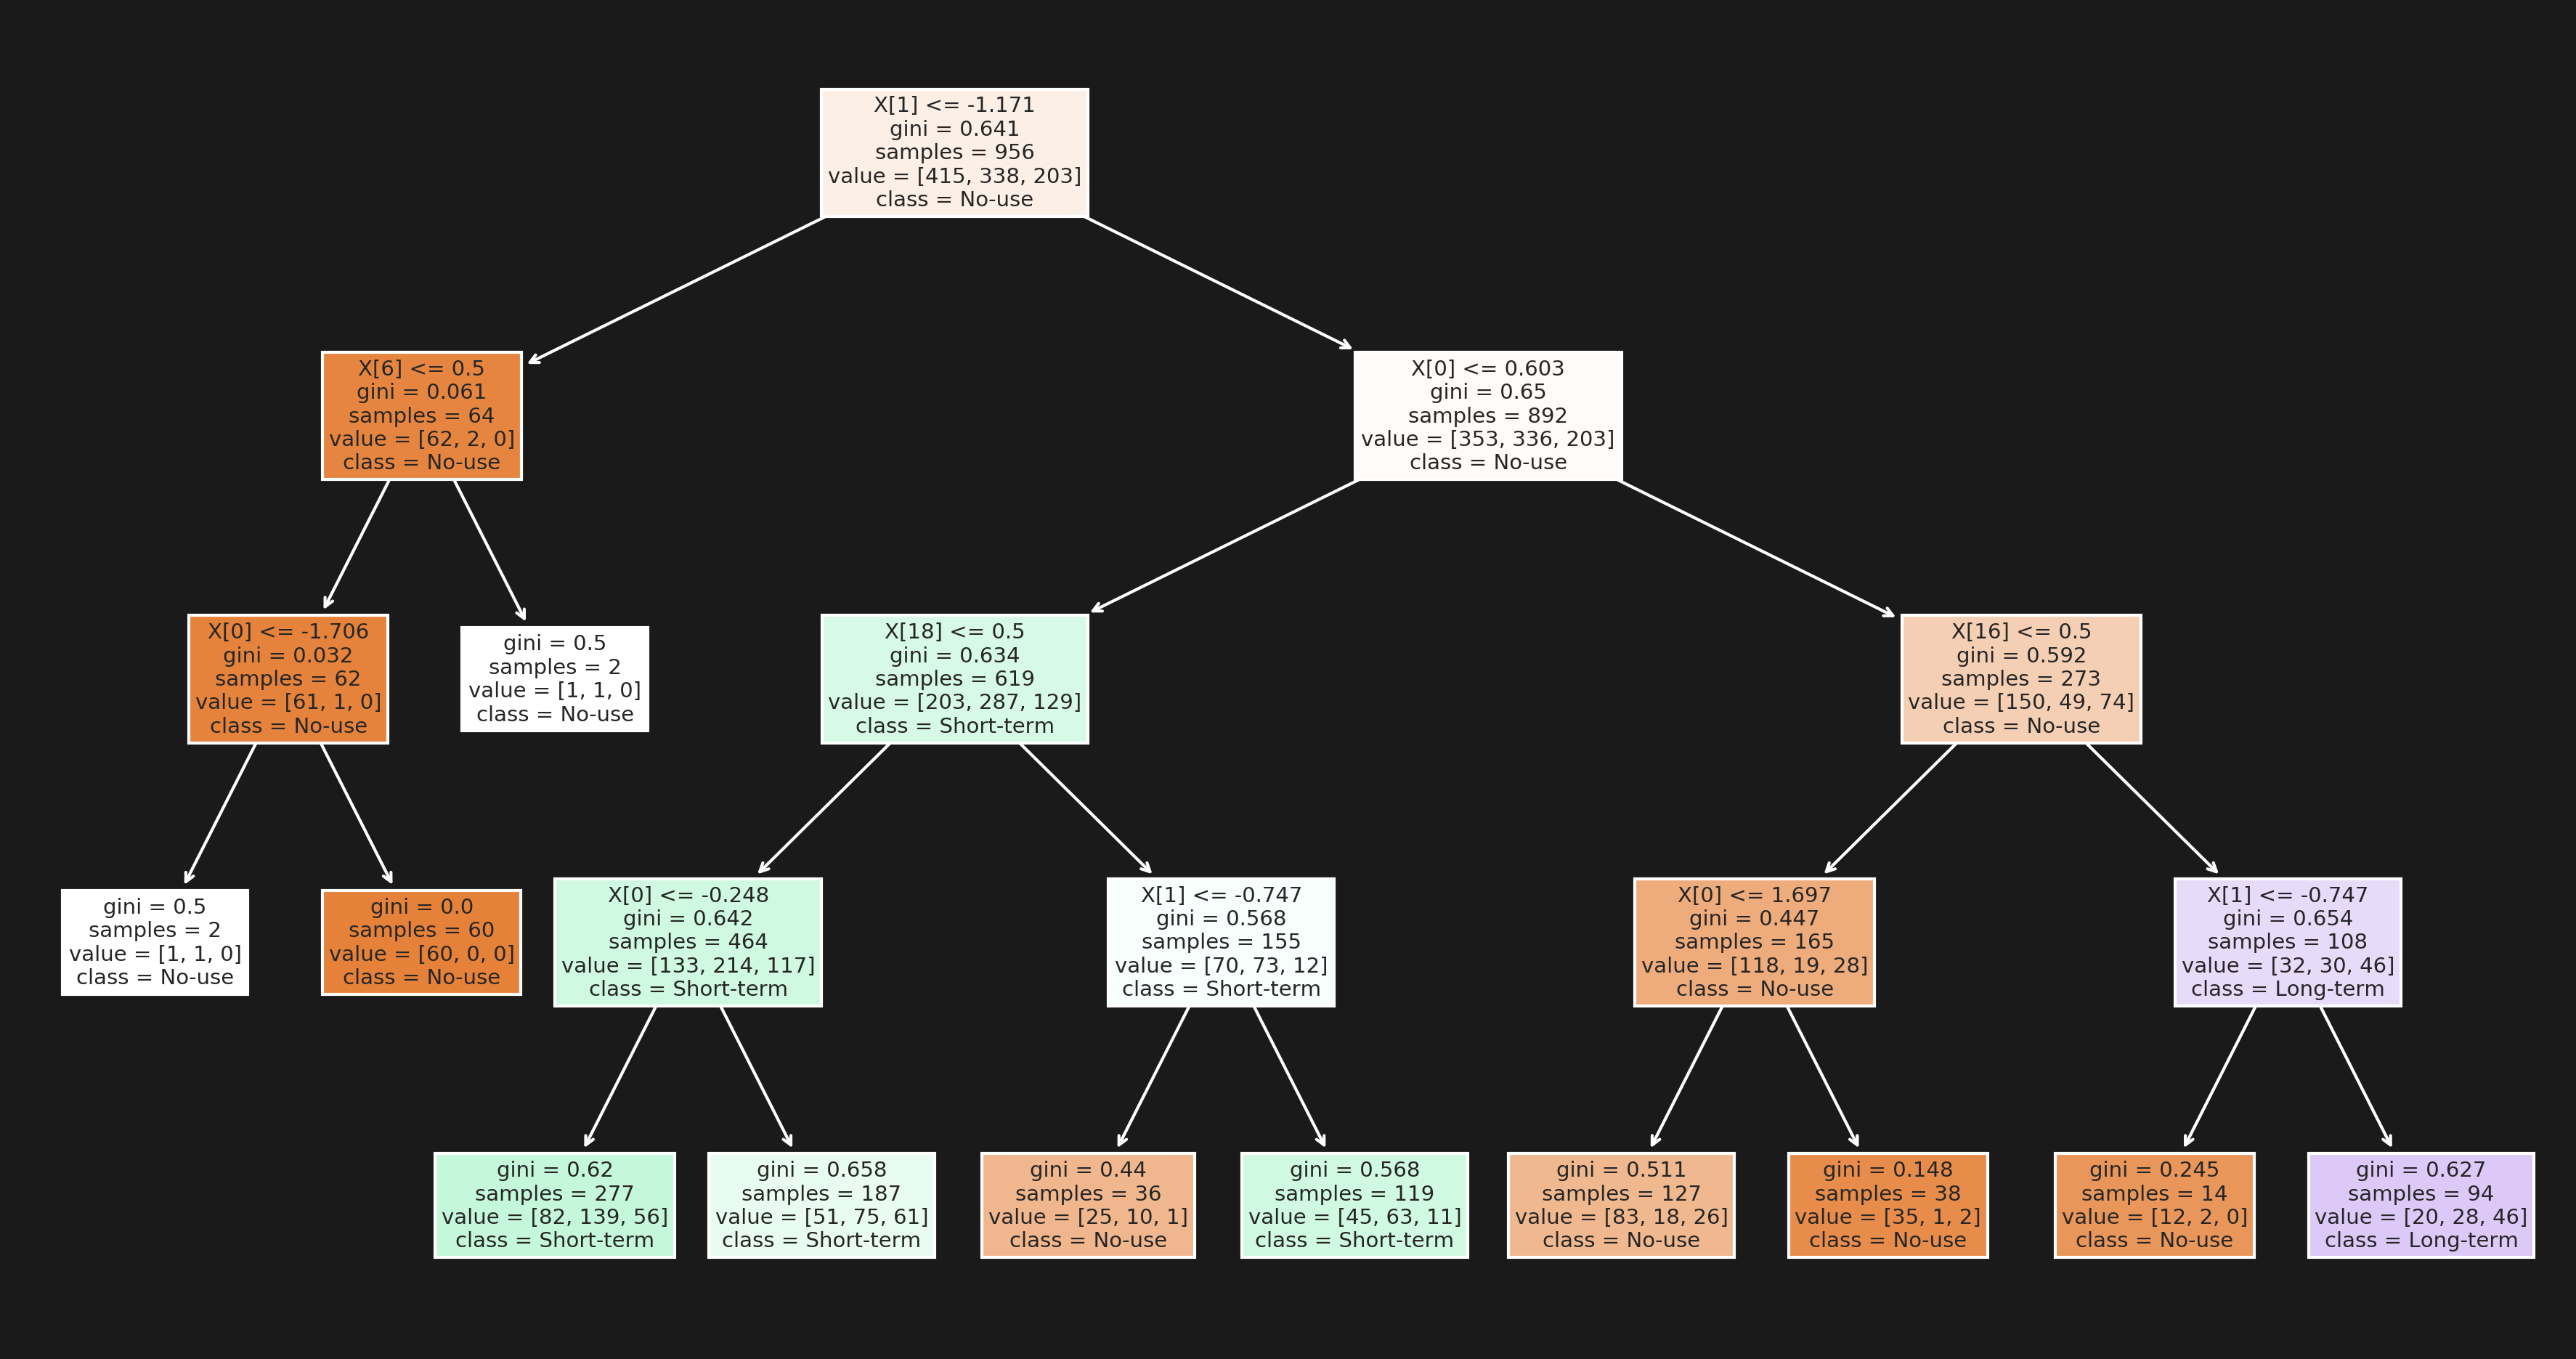

In [52]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15, 8), dpi=300, facecolor='k')
tree.plot_tree(final_model, class_names=['No-use', 'Short-term', 'Long-term'], filled=True)
plt.show();